In [1]:
## Loding libraries
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
## Preprocecing ##
jh_dir = "../../COVID-19"
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [3]:
## Definitions ##

In [4]:
### dates ###
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-05-06')
upto = last-pd.Timedelta(days=2)
index= pd.date_range(start=epoch, end=upto)

In [5]:
### Fitting a model ###
def fit_and_infer(sm=None, data=None, country=None, population=None, detection_rate=1,
                  b_beta_0=0.1, inits='random', iteration=2000, start=epoch, last=last):
    if data is None:
        C0 = confirmed.loc[start:last, country].values
        D0 = death.loc[start:last, country].values
        P = population
        data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'D0':D0, 
                'q0':detection_rate, 'b_beta_0':b_beta_0}
    fit = sm.sampling(data=data, iter=iteration, init=inits)
    print(fit)
    return az.from_pystan(fit, log_likelihood='log_lik')

In [6]:
### Extract data ###
def extract_var(var_name=None, data=None, start=epoch):
    d = data.posterior[var_name].stack(sample=('chain', 'draw')).values
    return pd.DataFrame(d, index=pd.date_range(start, end=start+pd.Timedelta(days=len(d)-1)))

In [7]:
### Drawing ###
def draw(data, index=index, name=None, line=None, label_name=None, value_name='value'):
    df = pd.DataFrame()
    dfs = []
    for label, samples in data.items():
        samples['Date'] = samples.index
        melted=pd.melt(samples, id_vars=['Date'])
        if label_name is not None:
            melted[label_name]=label
        dfs.append(melted)
    df = pd.concat(dfs)
    df = df.rename(columns={'value':value_name})
    if label_name is not None:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name, hue=label_name)
    else:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name)
    ax = g.axes[0][0]
    if line is not None:
        ax.axhline(y = line, color='grey', linestyle='--', linewidth=2, alpha=.7)
    g.savefig("{}.pdf".format(name))
    plt.show()

In [8]:
## Compile models ##
sm_const = pystan.StanModel(file="const.stan")
sm_const_q = pystan.StanModel(file="everyday-const-q.stan")
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af9c64d5eae9f5635306a489c55c8d64 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5cd8be6e46ccd02931578633bb84615c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee2085594df7feb36fc67a80a17cc305 NOW.


In [9]:
## Model Validation ##

In [10]:
#### Constant parameters ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

data = simulate(0.07, 0.2, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     112.41    0.84  23.34  72.32  96.09 110.35 126.63 163.13    775   1.01
b_beta       5.0e-3  1.5e-4 1.6e-3 2.1e-3 3.9e-3 4.8e-3 5.9e-3 8.6e-3    108   1.03
b[1]           0.01  6.5e-4   0.01 4.4e-4 3.8e-3 8.3e-3   0.02   0.05    458    1.0
b[2]           0.02  5.9e-4   0.02 2.1e-3   0.01   0.02   0.03   0.06    819    1.0
b[3]           0.04  6.5e-4   0.02   0.01   0.02   0.04   0.05   0.08    699    1.0
b[4]           0.04  6.3e-4   0.02   0.01   0.03   0.04   0.05   0.08    716    1.0
b[5]           0.05  6.5e-4   0.02   0.02   0.04   0.05   0.06   0.08    627    1.0
b[6]           0.05  6.1e-4   0.02   0.02   0.04   0.05   0.06   0.09    662    1.0
b[7]           0.05  5.9e-4   0.02   0.03   0.04   0.05

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      44.32    2.14  25.22  18.89  28.46  36.81  52.04 112.98    138   1.02
b_beta       4.0e-3  2.5e-4 1.7e-3 1.5e-3 2.7e-3 3.8e-3 5.0e-3 8.0e-3     47    1.1
b[1]           0.01  8.1e-4   0.02 2.3e-4 2.4e-3 6.0e-3   0.02   0.06    403   1.01
b[2]           0.03  1.5e-3   0.02 1.4e-3 8.0e-3   0.02   0.04   0.08    188   1.01
b[3]           0.04  1.3e-3   0.02 6.3e-3   0.02   0.04   0.05   0.09    254   1.02
b[4]           0.04  1.3e-3   0.02 7.9e-3   0.03   0.04   0.06   0.09    249   1.01
b[5]           0.05  1.1e-3   0.02   0.01   0.03   0.05   0.06   0.09    307   1.01
b[6]           0.05  1.1e-3   0.02   0.02   0.04   0.05   0.06   0.09    289   1.02
b[7]           0.05  1.1e-3   0.02   0.02   0.04   0.05

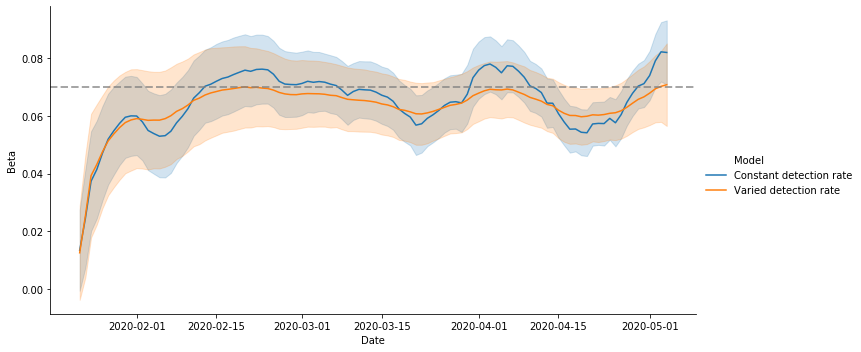

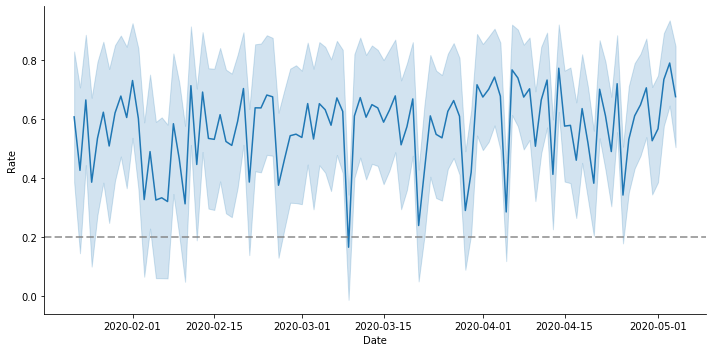

In [11]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='const_beta', line=0.07, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', label_name=None, value_name='Rate')

In [12]:
#### Step-like detection rate ####
from scipy.stats import poisson
def simulate(b, q1, q2, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q1)]
    D_obs = [0]
    R_obs = [0]
    q=[]
    for t in index:
        if t < pd.to_datetime('2020-04-01'):
            q.append(q1)
        else:
            q.append(q2)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C+NI
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q1}, np.array(q)

data, q_true = simulate(0.07, 1, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     102.92    0.24   9.95  84.47  95.94 102.42 109.54 123.48   1686    1.0
b_beta       2.8e-3  5.7e-5 8.5e-4 1.5e-3 2.2e-3 2.7e-3 3.3e-3 4.8e-3    223   1.02
b[1]           0.06  4.3e-4   0.01   0.03   0.05   0.06   0.06   0.08    879    1.0
b[2]           0.06  3.7e-4   0.01   0.03   0.05   0.06   0.06   0.08    956    1.0
b[3]           0.06  3.4e-4   0.01   0.04   0.05   0.06   0.06   0.08    988    1.0
b[4]           0.06  3.0e-4 9.8e-3   0.04   0.05   0.06   0.07   0.08   1045    1.0
b[5]           0.06  2.7e-4 9.2e-3   0.04   0.05   0.06   0.07   0.08   1140    1.0
b[6]           0.06  2.7e-4 9.0e-3   0.04   0.05   0.06   0.07   0.08   1091    1.0
b[7]           0.06  2.7e-4 8.7e-3   0.04   0.05   0.06

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     150.52    2.62  49.31  97.23 119.13 138.87 166.29 286.13    356   1.01
b_beta       2.8e-3  1.4e-4 1.2e-3 9.4e-4 2.0e-3 2.7e-3 3.5e-3 5.4e-3     68   1.07
b[1]           0.07  6.8e-4   0.02   0.03   0.06   0.07   0.08    0.1    513   1.01
b[2]           0.07  6.5e-4   0.01   0.03   0.06   0.07   0.08    0.1    516    1.0
b[3]           0.07  6.2e-4   0.01   0.04   0.06   0.07   0.08    0.1    524    1.0
b[4]           0.07  5.9e-4   0.01   0.04   0.06   0.07   0.08    0.1    529    1.0
b[5]           0.07  5.7e-4   0.01   0.04   0.06   0.07   0.08    0.1    522   1.01
b[6]           0.07  5.8e-4   0.01   0.04   0.06   0.07   0.08   0.09    493   1.01
b[7]           0.07  5.7e-4   0.01   0.04   0.06   0.07

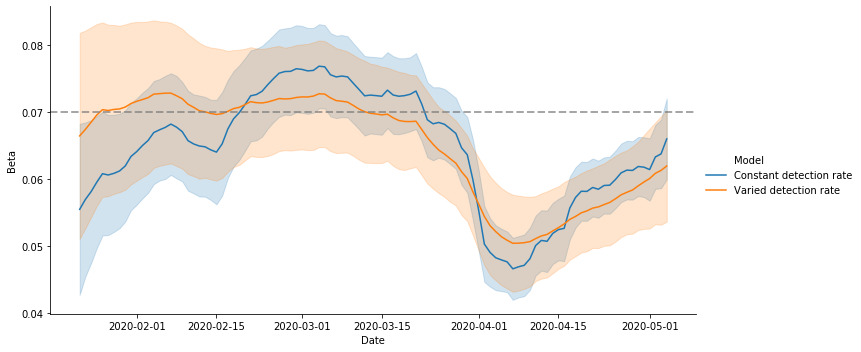

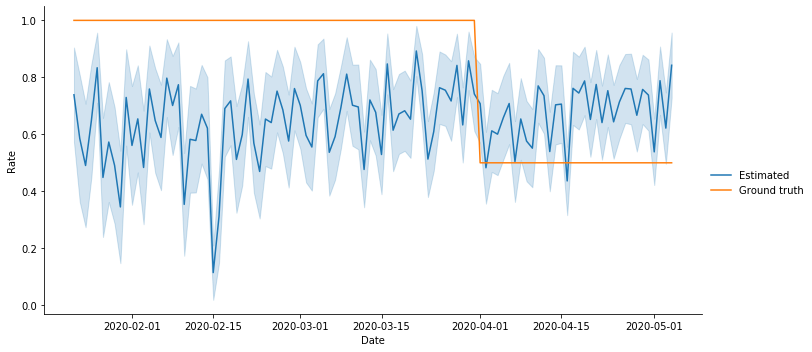

In [13]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
                     
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='step_beta', 
     label_name='Model', value_name='Beta', line=0.07)

q_true = pd.DataFrame(q_true, index)
draw({'Estimated':q, 'Ground truth':q_true}, name='step_q', value_name='Rate', label_name='')

In [14]:
#### Changing beta ####
from scipy.stats import poisson
def simulate(b0, b1, q0, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    q = [q0]
    D_obs = [0]
    R_obs = [0]
    b = [b0]
    for t in index:
        NI = poisson.rvs(b[-1]*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
        q.append(q0 + 0.05*np.random.randn(1)[0])
        b.append(b[-1] - b1)
 
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':1, 'q0':q0}, np.array(q), np.array(b)
data, q_true, b_true = simulate(0.16, 0.001, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     138.97    0.37  16.53 108.42 127.22 138.25  149.5 174.46   1968    1.0
b_beta       6.9e-3  2.6e-5 1.0e-3 5.0e-3 6.2e-3 6.8e-3 7.5e-3 9.1e-3   1608   1.01
b[1]           0.09  8.4e-4   0.03   0.02   0.07   0.09    0.1   0.14   1018    1.0
b[2]            0.1  4.8e-4   0.02   0.06   0.08    0.1   0.11   0.14   1614    1.0
b[3]            0.1  4.5e-4   0.02   0.07   0.09    0.1   0.11   0.13   1536    1.0
b[4]            0.1  4.1e-4   0.02   0.07   0.09    0.1   0.11   0.14   1627    1.0
b[5]           0.11  3.8e-4   0.02   0.08    0.1   0.11   0.12   0.14   1666    1.0
b[6]           0.11  3.5e-4   0.01   0.08    0.1   0.11   0.12   0.14   1770    1.0
b[7]           0.11  3.5e-4   0.01   0.08    0.1   0.11

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     107.92    1.48  41.08  64.39  81.89  97.87 120.71 210.63    768    1.0
b_beta       3.4e-3  7.5e-5 1.0e-3 1.7e-3 2.6e-3 3.2e-3 4.0e-3 5.8e-3    196    1.0
b[1]           0.11  1.0e-3   0.03   0.05    0.1   0.11   0.13   0.16    636   1.01
b[2]           0.11  7.2e-4   0.02   0.06    0.1   0.12   0.13   0.15    989    1.0
b[3]           0.12  6.8e-4   0.02   0.07    0.1   0.12   0.13   0.15   1011    1.0
b[4]           0.12  6.6e-4   0.02   0.07    0.1   0.12   0.13   0.15   1013    1.0
b[5]           0.12  6.3e-4   0.02   0.07   0.11   0.12   0.13   0.15   1026    1.0
b[6]           0.12  6.1e-4   0.02   0.08   0.11   0.12   0.13   0.15   1005    1.0
b[7]           0.12  5.9e-4   0.02   0.08   0.11   0.12

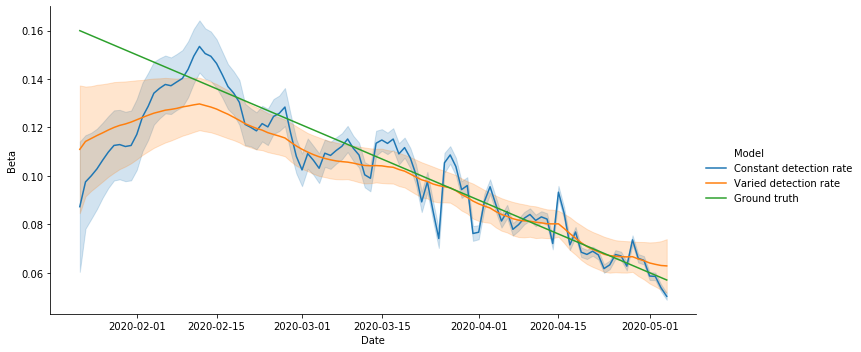

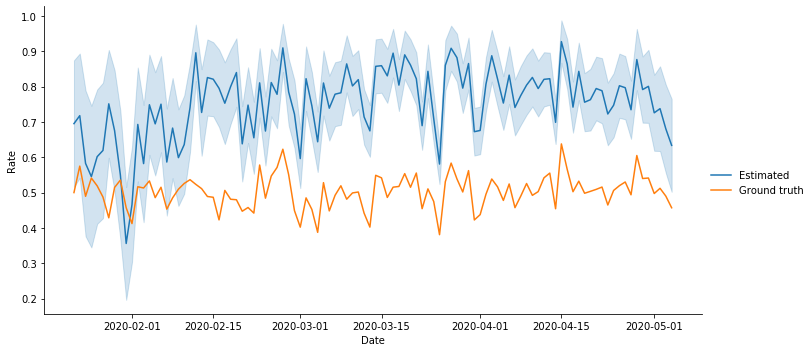

In [15]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
b = extract_var('b', infered_every)
                  
b_true = pd.DataFrame(b_true[:-1], index)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta, 'Ground truth':b_true}, 
     name='trend_beta', label_name='Model', value_name='Beta')

q_true = pd.DataFrame(q_true[:-1], index)
draw({'Estimated':q, 'Ground truth':q_true}, name='trend_q', value_name='Rate', label_name='')

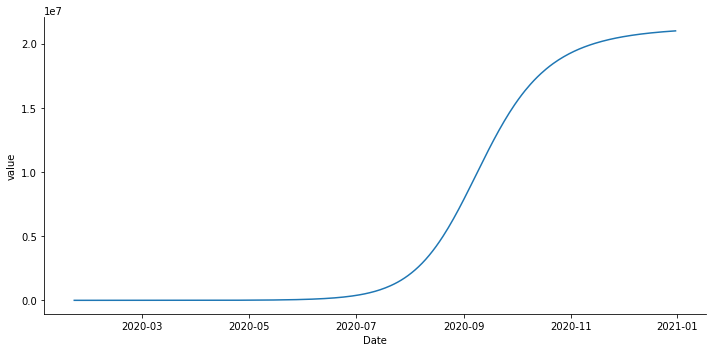

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      55.51   27.06  48.17   4.11   9.29  38.64 103.23 144.51      3   2.76
b_beta       9.2e-5  9.6e-6 3.1e-5 5.5e-5 7.2e-5 8.6e-5 1.0e-4 1.8e-4     10   1.49
b[1]           0.27    0.17   0.28   0.01   0.08   0.15   0.45   0.89      3   2.98
b[2]           0.29    0.16   0.33   0.01   0.08   0.15   0.46   1.05      4   1.95
b[3]           0.25    0.17   0.26   0.01   0.08   0.15   0.39   0.83      2   6.29
b[4]           0.28    0.15   0.24    0.1    0.1   0.15   0.39   0.83      2   5.68
b[5]           0.16    0.03   0.06    0.1    0.1   0.15   0.18   0.31      5    2.8
b[6]           0.16    0.03   0.06    0.1    0.1   0.15   0.18   0.31      5    2.8
b[7]           0.16    0.03   0.06    0.1    0.1   0.15

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      49.19    1.08   16.0  23.74  37.97  47.07  58.17  86.75    218   1.01
b_beta       9.3e-4  1.4e-5 1.7e-4 6.3e-4 8.1e-4 9.2e-4 1.0e-3 1.3e-3    142   1.02
b[1]           0.09  7.2e-4   0.01   0.07   0.08   0.09    0.1   0.11    216   1.01
b[2]           0.09  7.1e-4   0.01   0.07   0.09   0.09    0.1   0.11    211   1.01
b[3]           0.09  7.1e-4   0.01   0.07   0.09   0.09    0.1   0.11    203   1.01
b[4]           0.09  7.0e-410.0e-3   0.07   0.09   0.09    0.1   0.11    202   1.01
b[5]           0.09  6.9e-4 9.8e-3   0.07   0.09   0.09    0.1   0.11    200   1.01
b[6]           0.09  6.9e-4 9.6e-3   0.07   0.09   0.09    0.1   0.11    197   1.01
b[7]           0.09  6.9e-4 9.6e-3   0.07   0.09   0.09

In [16]:
#### Saturate ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

index=pd.date_range(start=epoch, end=pd.to_datetime('2020-12-31'))
data = simulate(0.10, 0.2, 100, 0.04, 0.001, 12000_0000,index)
C0 = pd.DataFrame(data['C0'][:-1], index)
draw({'Cumulative':C0})

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)

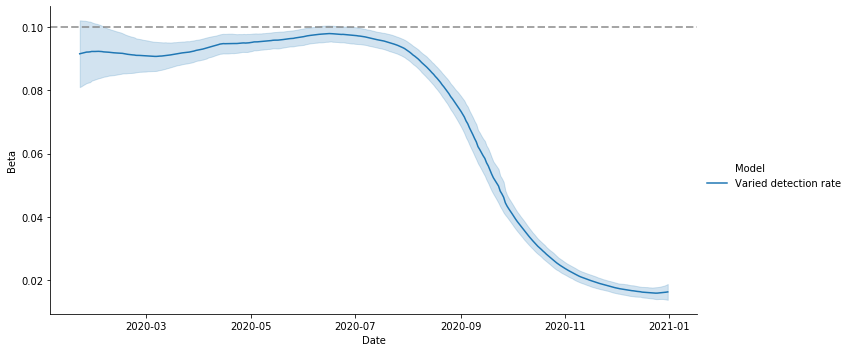

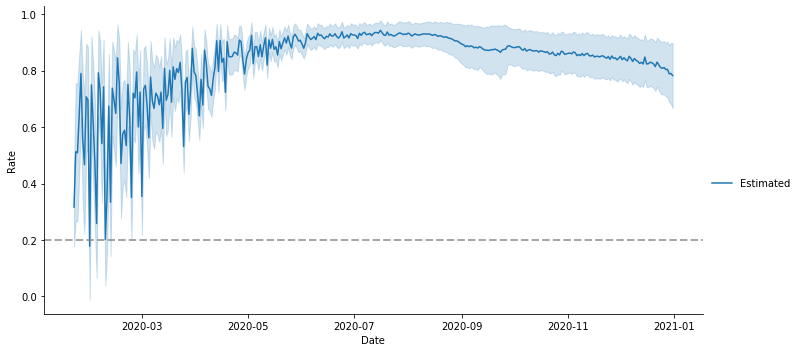

In [17]:
beta_const_q = extract_var('b', infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
draw({'Varied detection rate':beta}, name='saturate_beta', line=0.10, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='saturate_q', value_name='Rate', label_name='')

In [18]:
## Analysis ##
iteration = 10000

In [19]:
### Japanese case ###
P = 126_500_000
infer_const = fit_and_infer(sm=sm_const, country='Japan', population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country='Japan', population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country='Japan', population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      15.32    0.03   3.63   8.97  12.79  15.07   17.6  23.12  20131    1.0
b              0.08  5.6e-6 7.6e-4   0.08   0.08   0.08   0.08   0.09  18751    1.0
q               1.0  2.6e-6 4.6e-4    1.0    1.0    1.0    1.0    1.0  30451    1.0
NI[1]          1.41  6.5e-3   0.87   0.09   0.74   1.31   1.98   3.35  18077    1.0
NI[2]           1.5  6.5e-3    0.9   0.11   0.81   1.42   2.09   3.51  19227    1.0
NI[3]          1.61  6.7e-3   0.95   0.12   0.88   1.51   2.22   3.68  19959    1.0
NI[4]          2.65  6.5e-3   0.95   0.98   1.97   2.59   3.27   4.67  21418    1.0
NI[5]          1.81  7.7e-3   1.04   0.14   1.01   1.72   2.48   4.02  18179    1.0
NI[6]          3.27  7.0e-3   1.03   1.44   2.53   3.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.64  6.1e-3   0.86   0.44   1.03   1.48   2.07   3.75  19780    1.0
b_beta         0.06  5.1e-5 7.1e-3   0.05   0.05   0.06   0.06   0.07  19066    1.0
b[1]           0.09  5.9e-4   0.07 3.6e-3   0.03   0.07   0.12   0.29  16387    1.0
b[2]           0.14  7.5e-4   0.09   0.01   0.07   0.12   0.19   0.36  14685    1.0
b[3]           0.19  7.9e-4    0.1   0.03   0.11   0.17   0.24   0.41  15524    1.0
b[4]           0.23  7.8e-4    0.1   0.07   0.16   0.22   0.29   0.45  15770    1.0
b[5]           0.24  8.0e-4    0.1   0.07   0.17   0.24    0.3   0.46  15444    1.0
b[6]           0.27  7.3e-4   0.09   0.11    0.2   0.26   0.32   0.47  16722    1.0
b[7]           0.26  7.7e-4    0.1   0.09    0.2   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       5.76    0.09   5.55   1.11   2.64   4.12   6.85  20.57   3576    1.0
b_beta         0.01  1.1e-4 3.8e-3 8.0e-3   0.01   0.01   0.02   0.02   1184    1.0
b[1]           0.06  1.1e-3   0.06 1.6e-3   0.01   0.04    0.1   0.23   3670    1.0
b[2]            0.1  1.0e-3   0.07 7.6e-3   0.04   0.09   0.14   0.25   4293    1.0
b[3]           0.12  9.2e-4   0.06   0.02   0.07   0.12   0.16   0.26   4773    1.0
b[4]           0.14  7.9e-4   0.06   0.04    0.1   0.14   0.18   0.27   5352    1.0
b[5]           0.15  7.3e-4   0.06   0.05   0.11   0.15   0.19   0.27   5685    1.0
b[6]           0.16  7.0e-4   0.05   0.07   0.12   0.16   0.19   0.27   5533    1.0
b[7]           0.16  6.8e-4   0.05   0.07   0.13   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  4405.88   731.44
p_loo   1133.11        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       27   25.7%
 (0.5, 0.7]   (ok)         31   29.5%
   (0.7, 1]   (bad)         8    7.6%
   (1, Inf)   (very bad)   39   37.1%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   759.23    29.16
p_loo     92.15        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       13   12.4%
 (0.5, 0.7]   (ok)         11   10.5%
   (0.7, 1]   (bad)        67   63.8%
   (1, Inf)   (very bad)   14   13.3%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   745.09    28.91
p_loo     87.51        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5    4.8%
 (0.5, 0.7]   (ok)         13   12.4%
   (0.7, 1]   (bad)        78   74.3%
   (1, Inf)   (very bad)    9    8.6%

         rank     waic   p_waic   d_waic    weight       se      dse warning  \
Varied_q    0  677.847   53.887        0  0.971985  962.149        0    True   
Const_q     1  687.621  56.3507  9.77366  0.028015  25.9341  3.70963    True   
Const       2  5160.69  1510.51  4482.84         0  26.5235   971.48    True   

         waic_scale  
Varied_q   deviance  
Const_q    deviance  
Const      deviance  


/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


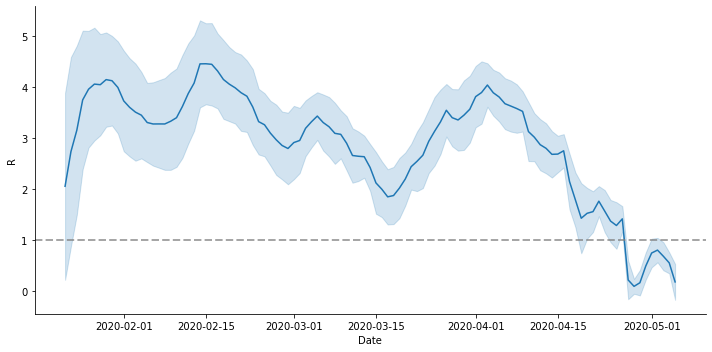

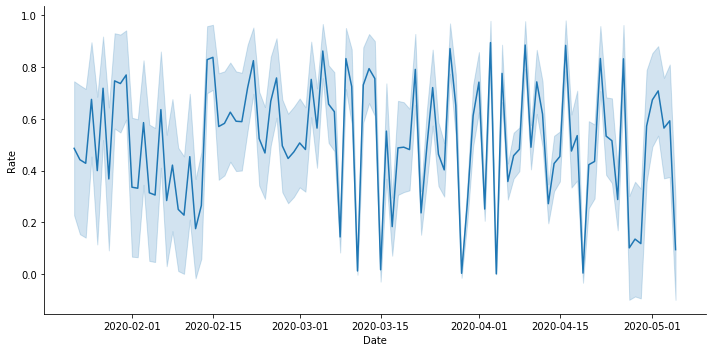

In [20]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_J = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_J}, line=1, name='R_Japan', value_name='R')
draw({'Detection rate':q}, name='q_Japan', value_name='Rate')

In [21]:
### China ###
P = 1_393_000_000
country='China'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     6722.8    0.47  84.96 6556.4 6665.4 6723.1 6780.7 6886.6  32744    1.0
b              0.06  1.4e-6 2.6e-4   0.06   0.06   0.06   0.06   0.06  35332    1.0
q               1.0  2.2e-7 3.8e-5    1.0    1.0    1.0    1.0    1.0  31149    1.0
NI[1]        442.27    0.08  17.25 408.64 430.73 442.13 453.77 476.01  49890    1.0
NI[2]        564.44    0.07  16.54  532.2 553.16  564.5 575.64 596.33  48699    1.0
NI[3]        676.02    0.08  16.49 643.73 664.92 676.02 687.04 708.34  47341    1.0
NI[4]        767.21    0.08  16.56 734.51 756.11 767.13 778.38 799.66  48702    1.0
NI[5]        838.12    0.07  17.02 804.68 826.55 838.19 849.42 871.72  53667    1.0
NI[6]        1320.4    0.08  17.11 1286.7 1308.8 1320

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     556.45    0.16  23.16 512.33 540.62 556.47 571.77  602.9  19723    1.0
b_beta       6.6e-3  8.3e-6 1.2e-3 4.6e-3 5.8e-3 6.5e-3 7.4e-3 9.4e-3  20894    1.0
b[1]           0.17  1.8e-4   0.03   0.12   0.15   0.17   0.19   0.23  23947    1.0
b[2]           0.47  1.7e-4   0.02   0.44   0.46   0.47   0.49   0.52  14522    1.0
b[3]           0.48  1.6e-4   0.02   0.44   0.47   0.48   0.49   0.52  13182    1.0
b[4]           0.47  1.5e-4   0.02   0.44   0.46   0.47   0.49   0.51  13937    1.0
b[5]           0.46  1.7e-4   0.02   0.42   0.45   0.46   0.48    0.5  13201    1.0
b[6]           0.98  2.2e-4   0.03   0.91   0.96   0.98    1.0   1.04  21818    1.0
b[7]           0.11  4.4e-5 6.9e-3    0.1   0.11   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     9780.1   27.39 1355.2 7456.0 8844.2 9663.7  1.1e4  1.3e4   2448    1.0
b_beta       1.1e-3  4.4e-6 2.6e-4 6.6e-4 9.0e-4 1.1e-3 1.2e-3 1.7e-3   3295    1.0
b[1]           0.16  2.0e-4   0.01   0.14   0.16   0.16   0.17   0.18   2607    1.0
b[2]           0.16  2.0e-410.0e-3   0.14   0.16   0.16   0.17   0.18   2546    1.0
b[3]           0.16  2.0e-4 9.9e-3   0.14   0.16   0.16   0.17   0.18   2482    1.0
b[4]           0.16  2.0e-4 9.8e-3   0.14   0.16   0.16   0.17   0.18   2380    1.0
b[5]           0.16  2.0e-4 9.8e-3   0.14   0.16   0.16   0.17   0.18   2326    1.0
b[6]           0.16  2.0e-4 9.7e-3   0.14   0.16   0.16   0.17   0.18   2236    1.0
b[7]           0.16  2.0e-4 9.5e-3   0.14   0.16   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo 42093.35  18578.45
p_loo   3958.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          2    1.9%
   (0.7, 1]   (bad)         8    7.6%
   (1, Inf)   (very bad)   95   90.5%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   979.03    24.48
p_loo    101.53        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          2    1.9%
   (0.7, 1]   (bad)        80   76.2%
   (1, Inf)   (very bad)   23   21.9%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densiti

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   947.48    22.88
p_loo     88.20        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)        98   93.3%
   (1, Inf)   (very bad)    6    5.7%



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,872.813,50.867,0,0.998681,27935.7,0,True,deviance
Const_q,1,890.893,57.4674,18.0798,0.00131892,22.4925,5.51967,True,deviance
Const,2,58525.7,12174.6,57652.9,0,21.2603,27407.6,True,deviance


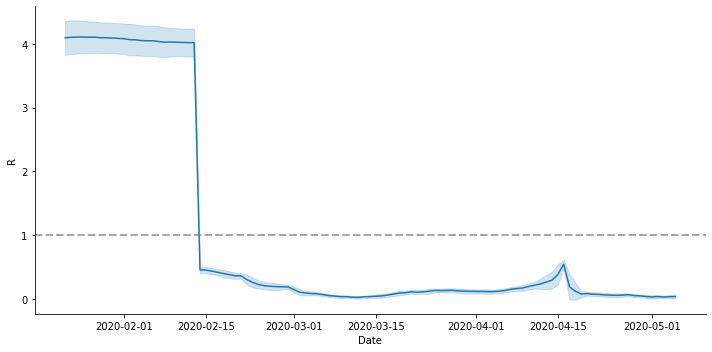

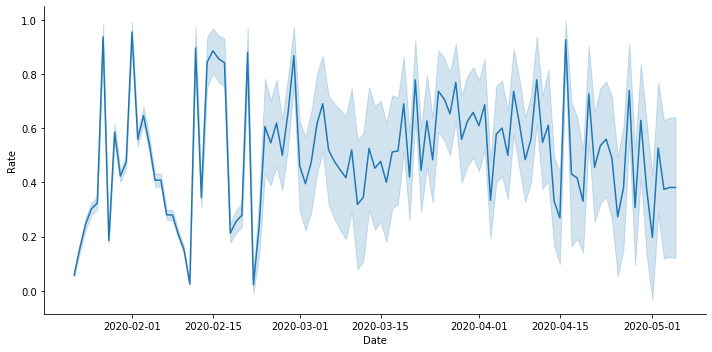

In [22]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_C = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_C}, line=1, name='R_China', value_name='R')
draw({'Detection rate':q}, name='q_China', value_name='Rate')

In [23]:
### US ###
P = 327_200_000
country='US'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     285.03    0.12  17.92 250.46 272.84 284.74 296.89 320.95  22083    1.0
b              0.09  5.9e-7 8.6e-5   0.09   0.09   0.09   0.09   0.09  21517    1.0
q               1.0  9.1e-8 1.5e-5    1.0    1.0    1.0    1.0    1.0  27323    1.0
NI[1]         25.37    0.03   4.81  16.04   22.1  25.38  28.63  34.82  23435    1.0
NI[2]          28.4    0.03   4.77  19.12  25.21  28.34  31.58  37.85  22641    1.0
NI[3]         29.87    0.03   5.11  19.95  26.35  29.85  33.37  39.95  22225    1.0
NI[4]         34.76    0.03   4.97  25.06  31.37  34.78  38.12  44.58  23681    1.0
NI[5]         35.32    0.03   5.33   24.9   31.7  35.28  38.98  45.76  23620    1.0
NI[6]         38.41    0.03   5.47   27.7  34.75   38

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.44  6.0e-3    0.8   0.34   0.87   1.29   1.83   3.43  17904    1.0
b_beta         0.03  5.3e-5 5.0e-3   0.02   0.03   0.03   0.03   0.04   8866    1.0
b[1]           0.06  4.3e-4   0.05 3.2e-3   0.02   0.04   0.08   0.19  13528    1.0
b[2]            0.1  5.1e-4   0.06   0.02   0.06   0.09   0.13   0.23  12072    1.0
b[3]           0.11  5.5e-4   0.06   0.02   0.07   0.11   0.15   0.25  10938    1.0
b[4]           0.13  5.5e-4   0.06   0.04   0.09   0.12   0.16   0.26  10467    1.0
b[5]           0.13  6.4e-4   0.06   0.03   0.09   0.12   0.16   0.26   8424    1.0
b[6]           0.13  6.5e-4   0.06   0.03   0.08   0.12   0.16   0.26   8174    1.0
b[7]           0.13  6.5e-4   0.06   0.03   0.09   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       3.07    0.04    2.6   0.64   1.56    2.4   3.74   9.45   4856    1.0
b_beta         0.02  8.5e-5 3.7e-3 9.9e-3   0.01   0.02   0.02   0.02   1929    1.0
b[1]           0.05  5.9e-4   0.05 2.2e-3   0.02   0.04   0.07   0.18   6717    1.0
b[2]           0.08  6.2e-4   0.05   0.01   0.04   0.07   0.11    0.2   6512    1.0
b[3]            0.1  6.2e-4   0.05   0.02   0.06   0.09   0.12   0.21   6157    1.0
b[4]           0.11  5.9e-4   0.05   0.04   0.07    0.1   0.14   0.22   6124    1.0
b[5]           0.11  6.2e-4   0.05   0.03   0.08   0.11   0.14   0.22   5550    1.0
b[6]           0.11  6.3e-4   0.05   0.03   0.08   0.11   0.14   0.22   5343    1.0
b[7]           0.11  6.1e-4   0.04   0.04   0.08   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo 128354.83  12716.02
p_loo  12588.14        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          2    1.9%
   (0.7, 1]   (bad)         2    1.9%
   (1, Inf)   (very bad)  101   96.2%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  1062.33    66.60
p_loo    112.23        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       23   21.9%
 (0.5, 0.7]   (ok)         11   10.5%
   (0.7, 1]   (bad)        53   50.5%
   (1, Inf)   (very bad)   18   17.1%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  1001.96    58.51
p_loo     87.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       16   15.2%
 (0.5, 0.7]   (ok)         10    9.5%
   (0.7, 1]   (bad)        73   69.5%
   (1, Inf)   (very bad)    6    5.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,939.936,56.2872,0,0.999989,21071.1,0,True,deviance
Const_q,1,985.246,73.6851,45.3101,1.12515e-05,57.8463,16.0681,True,deviance
Const,2,194768,45794.5,193828,0,54.9316,21061.9,True,deviance


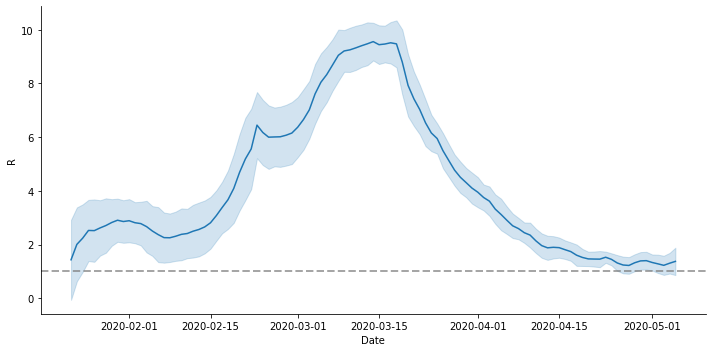

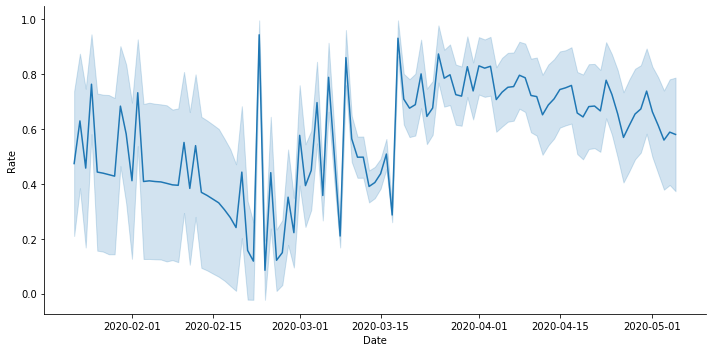

In [24]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_US = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_US}, line=1, name='R_US', value_name='R')
draw({'Detection rate':q}, name='q_US', value_name='Rate')

In [25]:
### Italy ###
P = 60_360_000
country='Italy'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    1008.9    0.23  34.78 942.57 985.37 1008.7 1032.1 1078.1  23232    1.0
b             0.07  1.0e-6 1.6e-4   0.07   0.07   0.07   0.07   0.07  24426    1.0
q              1.0  3.0e-7 4.8e-5    1.0    1.0    1.0    1.0    1.0  25995    1.0
NI[1]        71.53    0.05   8.06  55.83  66.09  71.53  76.93  87.31  25676    1.0
NI[2]        76.48    0.05    8.1  60.86  71.01  76.44  81.91  92.37  23695    1.0
NI[3]        81.63    0.05    8.4  65.14  75.94  81.61  87.33  98.11  25053    1.0
NI[4]        87.26    0.05   8.41  70.94  81.55  87.24  92.99 103.54  26767    1.0
NI[5]        93.32    0.05   8.65  76.47  87.53  93.32   99.1 110.32  27244    1.0
NI[6]       100.55    0.05    8.8  83.32  94.64 100.56 106.38 

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.8    0.02    1.0   0.45   1.09   1.59    2.3   4.28   4005    1.0
b_beta        0.02  4.0e-5 2.8e-3   0.01   0.01   0.02   0.02   0.02   4987    1.0
b[1]          0.02  2.9e-4   0.02 8.2e-4 8.8e-3   0.02   0.03   0.09   6624    1.0
b[2]          0.04  5.8e-4   0.03 2.3e-3   0.02   0.03   0.05   0.11   2475    1.0
b[3]          0.05  5.5e-4   0.03 5.4e-3   0.03   0.04   0.07   0.12   3206    1.0
b[4]          0.06  5.3e-4   0.03 9.0e-3   0.03   0.05   0.08   0.14   3833    1.0
b[5]          0.07  5.1e-4   0.03   0.01   0.04   0.06   0.09   0.14   4351    1.0
b[6]          0.07  5.7e-4   0.03   0.02   0.05   0.07   0.09   0.15   3661    1.0
b[7]          0.07  5.5e-4   0.04   0.02   0.05   0.07    0.1 

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.4    0.05   2.42   0.43   1.16   1.82   2.87   7.86   2814    1.0
b_beta        0.01  7.9e-5 3.0e-3 5.9e-3 8.8e-3   0.01   0.01   0.02   1420    1.0
b[1]          0.03  2.0e-3   0.06 7.9e-4 6.9e-3   0.02   0.03   0.25    877    1.0
b[2]          0.06  3.0e-3   0.08 2.4e-3   0.02   0.03   0.06   0.33    717    1.0
b[3]          0.09  3.4e-3    0.1 5.1e-3   0.03   0.05    0.1   0.37    807    1.0
b[4]          0.11  3.7e-3   0.11 8.4e-3   0.04   0.07   0.14   0.39    842    1.0
b[5]          0.13  3.9e-3   0.11   0.01   0.05   0.08   0.19    0.4    847    1.0
b[6]          0.16  4.2e-3   0.12   0.02   0.06   0.11   0.25   0.42    820    1.0
b[7]          0.17  4.3e-3   0.12   0.02   0.07   0.12   0.27 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo 40187.83  4257.24
p_loo   6250.47        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.1%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         7    7.4%
   (1, Inf)   (very bad)   87   91.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   935.18    45.71
p_loo     80.77        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20   21.1%
 (0.5, 0.7]   (ok)          7    7.4%
   (0.7, 1]   (bad)        59   62.1%
   (1, Inf)   (very bad)    9    9.5%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   935.87    40.81
p_loo     82.16        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       10   10.5%
 (0.5, 0.7]   (ok)          3    3.2%
   (0.7, 1]   (bad)        73   76.8%
   (1, Inf)   (very bad)    9    9.5%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,866.546,47.5045,0,0.609079,6547.68,0,True,deviance
Const_q,1,870.975,48.6708,4.4294,0.390921,41.2325,12.4098,True,deviance
Const,2,55343.5,13828.3,54476.9,0,38.2761,6445.74,True,deviance


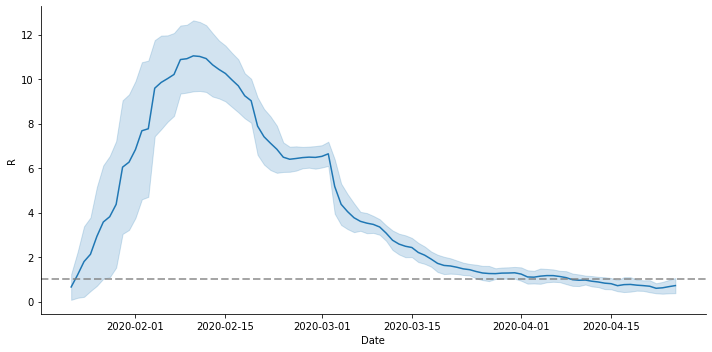

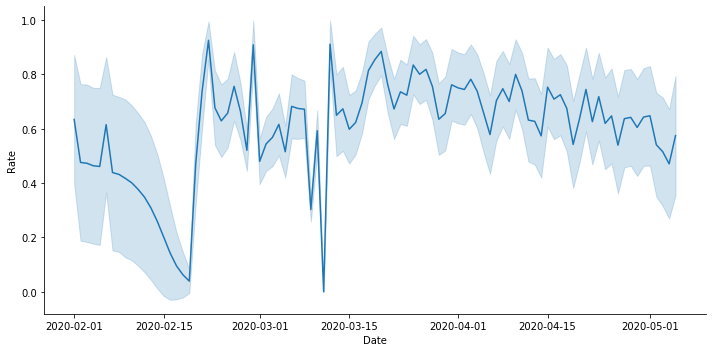

In [26]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_I = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_I}, line=1, name='R_Italy', value_name='R')
draw({'Detection rate':q}, name='q_Italy', value_name='Rate')

In [27]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      148.0    0.07  13.75 121.94 138.43 147.66 157.04 175.87  35489    1.0
b              0.06  3.9e-6 7.0e-4   0.06   0.06   0.06   0.06   0.06  31829    1.0
q               1.0  2.0e-6 3.5e-4    1.0    1.0    1.0    1.0    1.0  30178    1.0
NI[1]          9.51    0.02   2.96   3.68   7.51   9.52  11.51  15.35  19404    1.0
NI[2]         10.96    0.02   2.85   5.49   9.04  10.91  12.85  16.64  27520    1.0
NI[3]         10.69    0.02   3.09   4.55    8.6  10.68  12.76  16.77  23689    1.0
NI[4]          12.2    0.02   2.94   6.48  10.19  12.16  14.15  18.03  30586    1.0
NI[5]          12.9    0.02   3.03    7.1  10.82  12.86  14.96  18.84  28918    1.0
NI[6]         12.88    0.02    3.2   6.69  10.71  12.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.51    0.01   1.38   0.66   1.52   2.24    3.2   5.98   8498    1.0
b_beta       8.9e-3  2.6e-5 1.7e-3 6.0e-3 7.7e-3 8.7e-3 9.9e-3   0.01   4145    1.0
b[1]           0.06  1.1e-3   0.05 1.2e-3   0.01   0.04   0.09   0.19   2599    1.0
b[2]           0.09  9.5e-4   0.05   0.01   0.05   0.09   0.12    0.2   2975    1.0
b[3]            0.1  8.3e-4   0.05   0.02   0.06    0.1   0.13    0.2   3333    1.0
b[4]           0.11  7.3e-4   0.04   0.03   0.08   0.11   0.14    0.2   3650    1.0
b[5]           0.12  6.7e-4   0.04   0.04   0.09   0.11   0.14    0.2   3720    1.0
b[6]           0.12  6.4e-4   0.04   0.05   0.09   0.12   0.14    0.2   3794    1.0
b[7]           0.12  6.1e-4   0.04   0.06    0.1   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      547.6  477.75 801.07   0.38   1.07   1.91 1187.9 2377.6      3    2.7
b_beta       2.4e-3  5.2e-4 1.2e-3 6.8e-4 1.5e-3 2.3e-3 3.1e-3 5.2e-3      5    1.4
b[1]           0.12    0.04   0.13 1.5e-4 1.3e-3 5.2e-3   0.26    0.3      9   1.39
b[2]           0.16    0.07   0.13 5.0e-4 2.5e-3   0.24   0.27   0.31      3    3.5
b[3]           0.16    0.08   0.13 3.6e-4 2.7e-3   0.24   0.27   0.31      3   4.26
b[4]           0.16    0.08   0.13 6.7e-4 3.1e-3   0.24   0.27   0.31      3   4.58
b[5]           0.17    0.08   0.13 7.0e-4 3.3e-3   0.24   0.27   0.31      3   4.88
b[6]           0.17    0.08   0.13 5.4e-4 3.4e-3   0.24   0.27   0.31      3   4.95
b[7]           0.17    0.08   0.13 6.2e-4 3.8e-3   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  7118.01  1241.30
p_loo   1379.05        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        2    1.9%
 (0.5, 0.7]   (ok)         11   10.5%
   (0.7, 1]   (bad)        22   21.0%
   (1, Inf)   (very bad)   70   66.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   770.18    40.58
p_loo     93.44        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       18   17.1%
 (0.5, 0.7]   (ok)         12   11.4%
   (0.7, 1]   (bad)        67   63.8%
   (1, Inf)   (very bad)    8    7.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   726.11    27.23
p_loo     80.89        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        2    1.9%
 (0.5, 0.7]   (ok)         15   14.3%
   (0.7, 1]   (bad)        82   78.1%
   (1, Inf)   (very bad)    6    5.7%



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,665.438,50.5561,0,0.999426,1521.06,0,True,deviance
Const_q,1,715.421,66.0542,49.9834,0.000574462,38.4796,25.9298,True,deviance
Const,2,7836.93,1738.51,7171.49,0,25.3115,1508.6,True,deviance


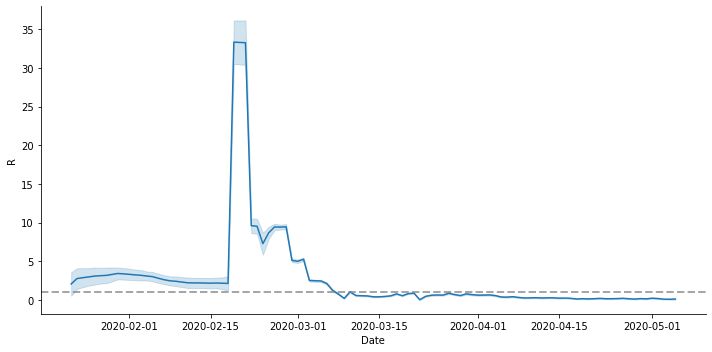

In [28]:
beta = extract_var(var_name='b', data=infer_const_q)
C = extract_var(var_name='C', data=infer_const_q)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K}, line=1, name='R_Korea', value_name='R')

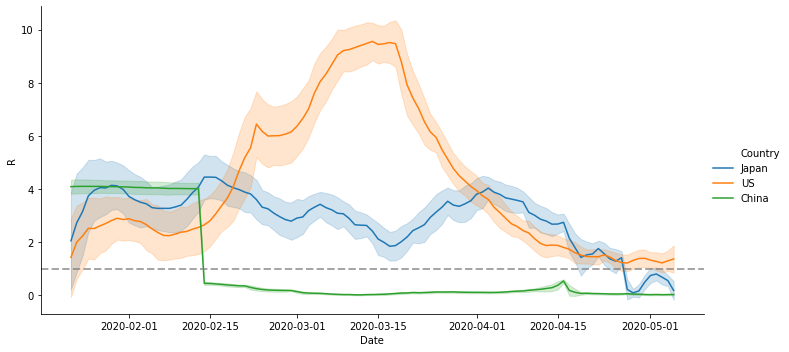

In [29]:
draw({'Japan':R_J, 'US':R_US, 'China':R_C}, line=1, name='R_multi', value_name='R', label_name='Country')

In [30]:
### Sweden ###
P = 10_230_000
country='Sweden'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     26.99    0.03    5.5  17.08  23.14  26.72  30.46  38.61  31221    1.0
b             0.08  3.8e-6 6.0e-4   0.08   0.08   0.08   0.08   0.08  24268    1.0
q              1.0  5.7e-6 1.0e-3    1.0    1.0    1.0    1.0    1.0  31506    1.0
NI[1]         2.39  8.9e-3   1.27   0.27   1.44   2.29   3.22   5.09  20434    1.0
NI[2]         2.53  9.7e-3   1.33   0.29   1.55   2.45   3.42   5.36  18772    1.0
NI[3]         2.71  9.8e-3   1.38   0.32    1.7   2.64   3.62   5.63  19668    1.0
NI[4]         2.92    0.01   1.44   0.37   1.87   2.86   3.86   5.92  16834    1.0
NI[5]         3.12    0.01   1.52   0.38   2.03   3.07   4.11   6.28  18900    1.0
NI[6]         3.35    0.01   1.56   0.53   2.22   3.29    4.4 

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      0.66  3.9e-3    0.5   0.07   0.31   0.54    0.9   1.93  16123    1.0
b_beta        0.02  4.7e-5 4.0e-3   0.02   0.02   0.02   0.03   0.03   7151    1.0
b[1]          0.03  2.2e-4   0.03 1.4e-3   0.01   0.02   0.04    0.1  14331    1.0
b[2]          0.04  3.0e-4   0.03 2.8e-3   0.02   0.04   0.06   0.13  11774    1.0
b[3]          0.05  3.5e-4   0.04 4.4e-3   0.03   0.05   0.07   0.14  10377    1.0
b[4]          0.06  4.1e-4   0.04 5.7e-3   0.03   0.05   0.08   0.16   8962    1.0
b[5]          0.07  4.6e-4   0.04 6.8e-3   0.04   0.06   0.09   0.16   8200    1.0
b[6]          0.07  4.8e-4   0.04 7.9e-3   0.04   0.06    0.1   0.17   8120    1.0
b[7]          0.07  5.0e-4   0.04 8.8e-3   0.04   0.07    0.1 

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      1.23  9.0e-3   0.93   0.17   0.61   1.02   1.59   3.64  10648    1.0
b_beta        0.01  7.4e-5 3.4e-3 7.5e-3   0.01   0.01   0.02   0.02   2074    1.0
b[1]          0.02  2.7e-4   0.02 9.2e-4 7.6e-3   0.02   0.03   0.09   7467    1.0
b[2]          0.04  3.9e-4   0.03 2.5e-3   0.02   0.03   0.05   0.11   5407    1.0
b[3]          0.05  4.6e-4   0.03 4.7e-3   0.02   0.04   0.06   0.13   4884    1.0
b[4]          0.05  5.3e-4   0.04 6.7e-3   0.03   0.05   0.07   0.14   4352    1.0
b[5]          0.06  5.7e-4   0.04 9.5e-3   0.04   0.06   0.08   0.15   4214    1.0
b[6]          0.07  6.1e-4   0.04   0.01   0.04   0.06   0.09   0.16   4040    1.0
b[7]          0.08  6.7e-4   0.04   0.01   0.05   0.07    0.1 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo  3080.41   326.59
p_loo    690.48        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        7    7.4%
 (0.5, 0.7]   (ok)         22   23.2%
   (0.7, 1]   (bad)        33   34.7%
   (1, Inf)   (very bad)   33   34.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   761.39    50.30
p_loo     92.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       25   26.3%
 (0.5, 0.7]   (ok)          6    6.3%
   (0.7, 1]   (bad)        49   51.6%
   (1, Inf)   (very bad)   15   15.8%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   689.00    39.82
p_loo     66.97        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20   21.1%
 (0.5, 0.7]   (ok)          5    5.3%
   (0.7, 1]   (bad)        61   64.2%
   (1, Inf)   (very bad)    9    9.5%



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,634.243,39.594,0,0.999999,378.964,0,True,deviance
Const_q,1,705.11,64.1666,70.8671,8.83271e-07,46.3524,26.5151,True,deviance
Const,2,3212.16,756.355,2577.92,0,36.5844,379.151,True,deviance


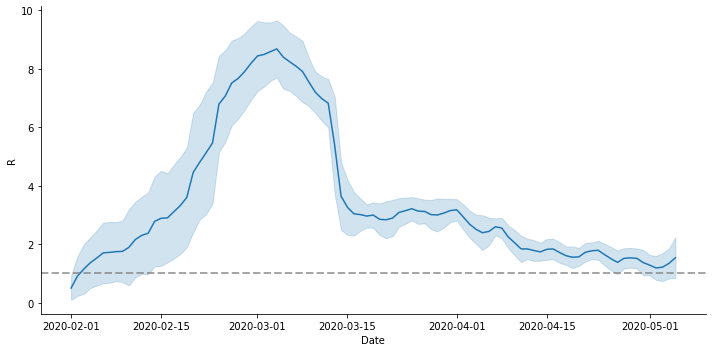

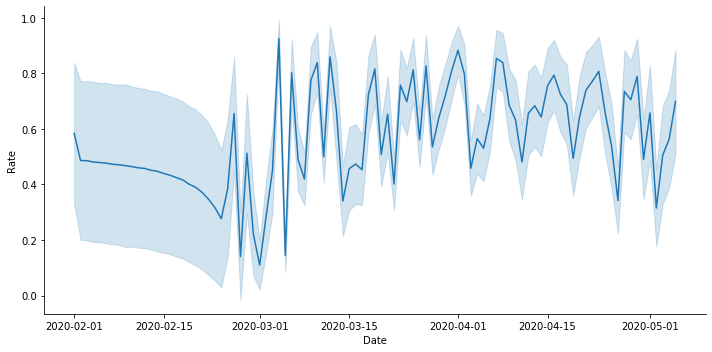

In [31]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_S = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_S}, line=1, name='R_Sweden', value_name='R')
draw({'Detection rate':q}, name='q_Sweden', value_name='Rate')

In [32]:
### Denmark ###
P = 5_806_000
country='Denmark'
start=pd.to_datetime('2020-03-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    261.76    0.13  16.59 230.02 250.39 261.52 272.88 294.68  16527    1.0
b             0.07  6.3e-6 8.3e-4   0.07   0.07   0.07   0.07   0.07  17790    1.0
q              1.0 10.0e-6 1.6e-3   0.99    1.0    1.0    1.0    1.0  24565    1.0
NI[1]         19.1    0.03   4.19  10.93  16.23  19.07  21.94  27.26  21699    1.0
NI[2]        22.09    0.03   4.06  14.21  19.32  22.11  24.85  30.05  20387    1.0
NI[3]        25.61    0.03   4.05  17.84  22.86  25.54  28.28  33.74  21246    1.0
NI[4]        23.48    0.03    4.4  14.73   20.5   23.5  26.43  32.14  22687    1.0
NI[5]        33.07    0.03   4.03  25.24  30.35  33.04  35.75  41.11  23045    1.0
NI[6]        26.76    0.03   4.66  17.57  23.63  26.75  29.87 

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      3.44    0.05   1.82   0.93   2.11   3.11    4.4   7.87   1365    1.0
b_beta        0.02  7.5e-5 3.2e-3   0.01   0.01   0.02   0.02   0.02   1818    1.0
b[1]          0.23    0.02   0.27 1.3e-3   0.01   0.09   0.39   0.93    244   1.01
b[2]          0.46    0.02   0.29   0.03   0.28   0.41   0.57   1.17    228   1.03
b[3]          0.52    0.02   0.28   0.14   0.33   0.44   0.62   1.23    294   1.01
b[4]          0.52    0.02   0.28   0.15   0.33   0.45   0.62   1.23    308   1.01
b[5]          0.55    0.02    0.3   0.19   0.35   0.46   0.66    1.3    328   1.01
b[6]          0.55    0.02    0.3   0.18   0.35   0.46   0.66   1.31    327   1.01
b[7]           0.9    0.05   0.49   0.29   0.46   0.78   1.35 

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    120.06   110.1 581.22   1.49    2.9   4.13   6.51 1981.3     28   1.08
b_beta      8.9e-3  1.3e-4 2.9e-3 4.7e-3 6.9e-3 8.5e-3   0.01   0.02    450   1.01
b[1]          0.52    0.14   0.31 1.4e-3   0.36   0.65   0.73   0.87      5   1.43
b[2]          0.65    0.05    0.2 5.1e-3   0.62   0.69   0.76    0.9     19   1.19
b[3]          0.66    0.05   0.19 7.1e-3   0.62   0.69   0.76    0.9     17   1.22
b[4]          0.66    0.05   0.19 5.5e-3   0.62   0.69   0.76    0.9     17   1.22
b[5]          0.66    0.04   0.18   0.01   0.63    0.7   0.76    0.9     18   1.21
b[6]          0.66    0.04   0.18   0.02   0.63    0.7   0.76    0.9     18   1.21
b[7]          0.67    0.04   0.18   0.03   0.63    0.7   0.76 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 66 log-likelihood matrix

       Estimate       SE
IC_loo  2243.90   242.05
p_loo    492.21        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        4    6.1%
 (0.5, 0.7]   (ok)         10   15.2%
   (0.7, 1]   (bad)        18   27.3%
   (1, Inf)   (very bad)   34   51.5%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 66 log-likelihood matrix

       Estimate       SE
IC_loo   633.72    27.29
p_loo     79.90        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        2    3.0%
 (0.5, 0.7]   (ok)          8   12.1%
   (0.7, 1]   (bad)        47   71.2%
   (1, Inf)   (very bad)    9   13.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Computed from 20000 by 66 log-likelihood matrix

       Estimate       SE
IC_loo   583.39    13.25
p_loo     57.92        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.5%
 (0.5, 0.7]   (ok)          1    1.5%
   (0.7, 1]   (bad)        60   90.9%
   (1, Inf)   (very bad)    4    6.1%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,535.111,33.7759,0,0.999734,249.675,0,True,deviance
Const_q,1,578.611,52.3478,43.5007,0.000266255,20.1706,20.8877,True,deviance
Const,2,2242.65,491.583,1707.54,2.03194e-237,11.8651,253.723,True,deviance


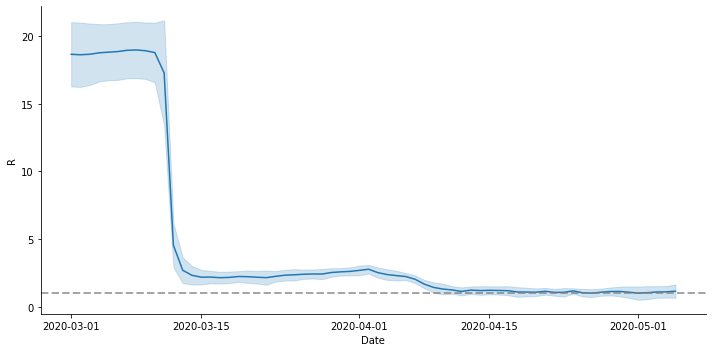

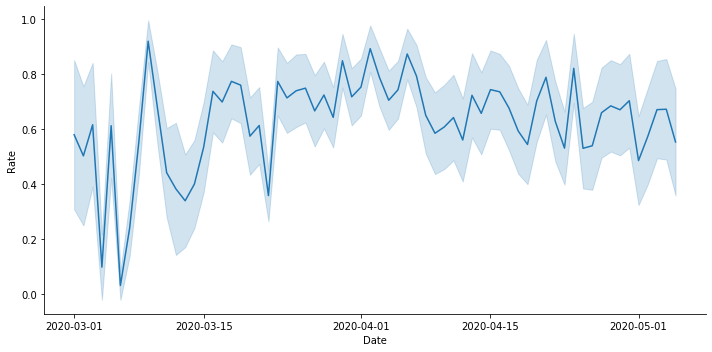

In [33]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_D = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_D}, line=1, name='R_Denmark', value_name='R')
draw({'Detection rate':q}, name='q_Denmark', value_name='Rate')

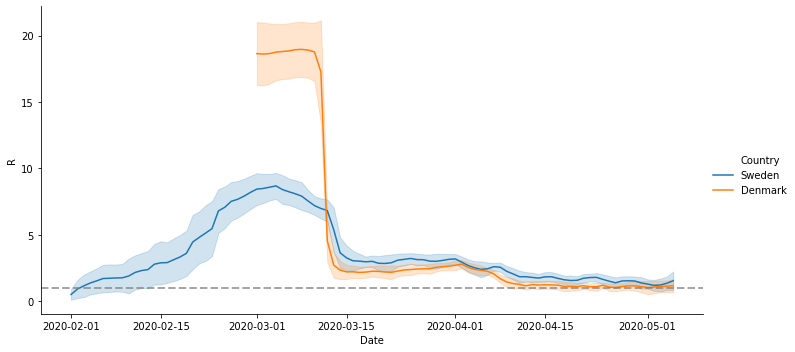

In [34]:
draw({'Sweden':R_S, 'Denmark':R_D,}, line=1, name='R_Nordic', value_name='R', label_name='Country')

In [35]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer_1 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer_01 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
                        detection_rate=0.1)
infer_001 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
                        detection_rate=0.01)
infer_0001 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
                        detection_rate=0.001)
# infer_0 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
#                         detection_rate=0)
loo = az.loo(infer_1, pointwise=True)
print(loo)
loo = az.loo(infer_01, pointwise=True)
print(loo)
loo = az.loo(infer_001, pointwise=True)
print(loo)
loo = az.loo(infer_0001, pointwise=True)
print(loo)
az.compare({'1':infer_1, '0.1':infer_01, '0.01':infer_001, '0.001':infer_0001})

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.52    0.02    1.4   0.67   1.53   2.23   3.21   6.05   7751    1.0
b_beta       8.9e-3  2.5e-5 1.7e-3 6.0e-3 7.7e-3 8.8e-3 9.9e-3   0.01   4427    1.0
b[1]           0.06  1.1e-3   0.05 1.3e-3   0.01   0.04    0.1   0.18   2640    1.0
b[2]           0.09  9.4e-4   0.05   0.01   0.05   0.09   0.12    0.2   2919    1.0
b[3]            0.1  8.3e-4   0.05   0.02   0.07    0.1   0.13    0.2   3194    1.0
b[4]           0.11  7.1e-4   0.04   0.03   0.08   0.11   0.14    0.2   3653    1.0
b[5]           0.12  6.4e-4   0.04   0.04   0.09   0.11   0.14    0.2   3891    1.0
b[6]           0.12  6.1e-4   0.04   0.05   0.09   0.12   0.14    0.2   3903    1.0
b[7]           0.12  5.5e-4   0.04   0.06    0.1   0.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      23.52    0.28   16.6   3.34  11.28   19.8  31.42  66.21   3479    1.0
b_beta         0.01  2.5e-5 1.9e-3 7.2e-3 9.0e-3   0.01   0.01   0.01   5743    1.0
b[1]           0.15  2.6e-3    0.1 2.5e-3   0.04   0.15   0.22   0.35   1548    1.0
b[2]           0.19  1.8e-3   0.08   0.03   0.14   0.19   0.24   0.36   2249    1.0
b[3]            0.2  1.6e-3   0.08   0.05   0.15   0.19   0.24   0.36   2325    1.0
b[4]            0.2  1.5e-3   0.07   0.08   0.15    0.2   0.25   0.36   2427    1.0
b[5]           0.21  1.4e-3   0.07   0.09   0.16    0.2   0.25   0.36   2488    1.0
b[6]           0.21  1.3e-3   0.07    0.1   0.16    0.2   0.24   0.35   2509    1.0
b[7]           0.21  1.3e-3   0.06   0.11   0.16    0

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     246.81    3.41 170.96  27.45 123.41 210.51 330.46 676.68   2516    1.0
b_beta         0.01  2.8e-5 1.9e-3 7.5e-3 9.4e-3   0.01   0.01   0.01   4854    1.0
b[1]           0.16  4.8e-3   0.13 2.2e-3   0.03   0.16   0.24   0.45    729   1.01
b[2]           0.21  3.8e-3    0.1   0.04   0.15    0.2   0.26   0.47    761   1.01
b[3]           0.22  3.7e-3    0.1   0.06   0.16   0.21   0.27   0.47    718   1.01
b[4]           0.23  3.6e-3   0.09   0.09   0.17   0.21   0.27   0.47    681   1.01
b[5]           0.23  3.5e-3   0.09    0.1   0.17   0.21   0.27   0.47    661   1.01
b[6]           0.23  3.5e-3   0.09   0.11   0.17   0.21   0.27   0.47    648   1.01
b[7]           0.23  3.5e-3   0.09   0.11   0.18   0.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     2320.7    31.3 1647.5 221.16 1135.1 1949.7 3113.5 6534.3   2771    1.0
b_beta         0.01  3.1e-5 2.2e-3 8.9e-3   0.01   0.01   0.01   0.02   4738    1.0
b[1]           0.17  5.3e-3   0.15 2.2e-3   0.03   0.16   0.25   0.49    822    1.0
b[2]           0.23  4.4e-3   0.13   0.04   0.15   0.21   0.28   0.52    857    1.0
b[3]           0.23  4.3e-3   0.12   0.06   0.16   0.22   0.28   0.52    827    1.0
b[4]           0.24  4.2e-3   0.12   0.08   0.17   0.22   0.28   0.52    801    1.0
b[5]           0.25  4.2e-3   0.12    0.1   0.18   0.23   0.28   0.52    765    1.0
b[6]           0.25  4.2e-3   0.11   0.11   0.18   0.23   0.28   0.52    750    1.0
b[7]           0.25  4.1e-3   0.11   0.12   0.19   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   769.75    41.15
p_loo     93.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       17   16.2%
 (0.5, 0.7]   (ok)         18   17.1%
   (0.7, 1]   (bad)        61   58.1%
   (1, Inf)   (very bad)    9    8.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   779.67    42.80
p_loo     90.89        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       22   21.0%
 (0.5, 0.7]   (ok)         11   10.5%
   (0.7, 1]   (bad)        60   57.1%
   (1, Inf)   (very bad)   12   11.4%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   781.41    42.87
p_loo     90.46        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       21   20.0%
 (0.5, 0.7]   (ok)         12   11.4%
   (0.7, 1]   (bad)        67   63.8%
   (1, Inf)   (very bad)    5    4.8%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   784.15    43.23
p_loo     93.34        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       19   18.1%
 (0.5, 0.7]   (ok)          8    7.6%
   (0.7, 1]   (bad)        63   60.0%
   (1, Inf)   (very bad)   15   14.3%



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
1,0,714.781,65.8101,0,0.541079,38.6181,0,True,deviance
0.1,1,715.575,58.8445,0.794435,0.216418,34.3212,19.6597,True,deviance
0.001,2,717.584,60.0544,2.8031,0.173283,35.266,21.4594,True,deviance
0.01,3,718.986,59.2482,4.2054,0.0692197,35.6663,20.9639,True,deviance


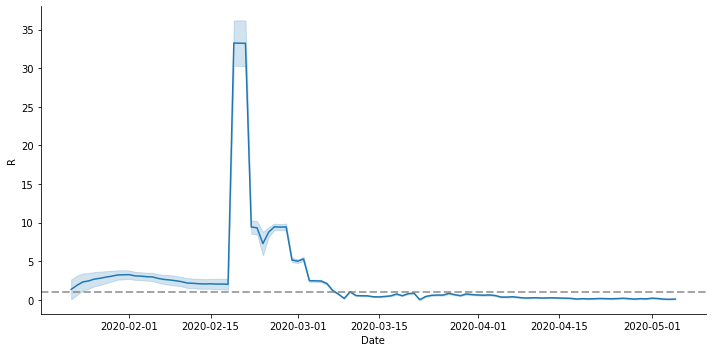

In [36]:
infer=infer_1
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K1 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K1}, line=1, name='R_Korea1', value_name='R')

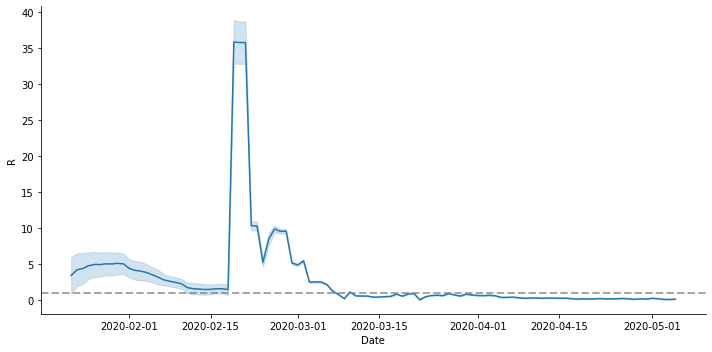

In [37]:
infer=infer_01
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K01 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K01}, line=1, name='R_Korea01', value_name='R')

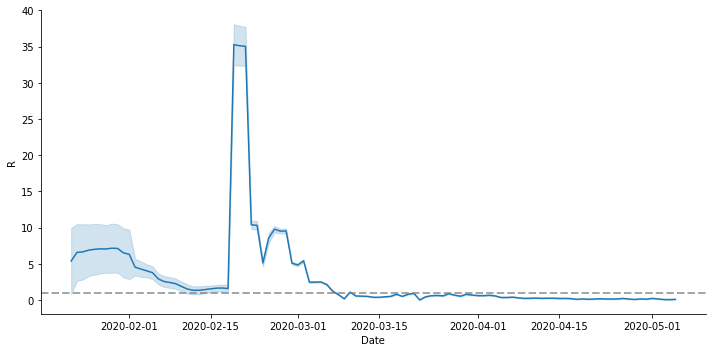

In [38]:
infer=infer_001
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K001 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K001}, line=1, name='R_Korea001', value_name='R')

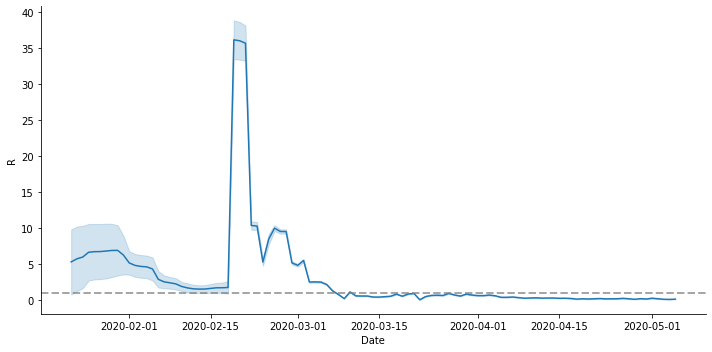

In [39]:
infer=infer_0001
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K0001 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K0001}, line=1, name='R_Korea0001', value_name='R')